In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from __future__ import annotations
from dataclasses import dataclass, field, replace
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any

In [4]:
from RaTag.datatypes import Run, S2Areas # type: ignore
import RaTag.dataIO as dataIO # type: ignore
import RaTag.config as config # type: ignore
import RaTag.transport as transport # type: ignore
import RaTag.plotting as plotting # type: ignore
import RaTag.transformations as transf # type: ignore
import RaTag.constructors as constructors # type: ignore
import RaTag.analysis as analysis # type: ignore
import RaTag.cuts as cuts # type: ignore
# import RaTag.measurements as meas

In [5]:
def prepare_set(s: SetPmt, run: Run) -> SetPmt:
    s1 = constructors.estimate_s1_from_batches(s, n_batches=1, batch_size=20, flag_plot=False)
    s1 = constructors.set_fields(s1, drift_gap_cm=run.drift_gap, el_gap_cm=run.el_gap, gas_density=run.gas_density)
    s1 = constructors.set_transport_properties(s1, drift_gap_cm=run.drift_gap, transport=None)
    return s1

# Define RUN8

In [6]:
base_dir = Path('/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec')
set_path = base_dir / 'FieldScan_Gate100_Anode2000'
wfm_paths = sorted(set_path.glob('*.wfm'))

In [ ]:
run8 = Run(
    root_directory = base_dir,
    run_id = "RUN8",
    el_field = 2375,            # V/cm
    target_isotope = "Th228",
    pressure = 2.0,             # bar
    temperature = 297,          # K
    sampling_rate = 5e9,
    el_gap = 0.8,               # cm
    drift_gap = 1.4,            # cm

    width_s2 = 20                # µs 
)

run8 = constructors.populate_run(run8)
run8 = transport.with_gas_density(run8)

run8.gas_density

4.877421222922505e+19

## Adapt data reading for FastFrames

In [8]:
wf = dataIO.load_wfm(str(wfm_paths[3]))
wf.ff

True

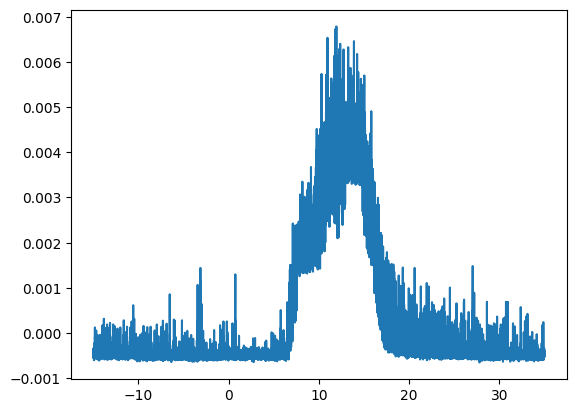

In [19]:
t, V_avg = transf.average_waveform(wfm_paths[:2])
plt.plot(t*1e6, V_avg)

In [10]:
transf.find_s1_in_avg(t, V_avg)

np.int64(59324)

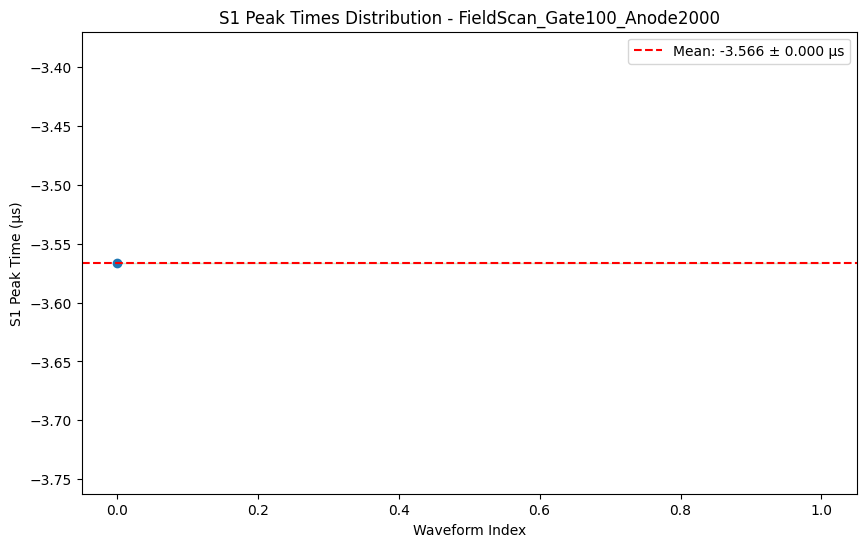

In [22]:
set_transf = constructors.estimate_s1_from_batches(run8.sets[0], n_batches=1)

In [15]:
set_transf.metadata

{'anode': 2000,
 'gate': 100,
 't_s1': np.float64(-3.566),
 't_s1_std': np.float64(0.0)}

In [23]:
run8 = replace(run8, sets=[prepare_set(s, run8) for s in run8.sets])

In [25]:
IntConfig = config.IntegrationConfig()
IntConfig, run8.width_s2

(IntegrationConfig(n_pedestal=2000, ma_window=9, threshold=0.8, dt=0.0002), 20)

In [12]:
IntConfig

IntegrationConfig(n_pedestal=2000, ma_window=9, threshold=0.8, dt=0.0002, integrator=<function integrate_trapz at 0x12b796f70>)

In [31]:
dataIO.load_wfm(set_transf.source_dir / set_transf.filenames[3])

Waveform(t=array([-1.50000e-05, -1.49998e-05, -1.49996e-05, ...,  3.49994e-05,
        3.49996e-05,  3.49998e-05]), v=array([[-0.0002, -0.0002, -0.0002, ..., -0.0006, -0.0002, -0.0002],
       [ 0.0002,  0.0002,  0.0002, ...,  0.0002,  0.0002, -0.0002],
       [-0.0002, -0.0006, -0.0006, ..., -0.0006, -0.0006, -0.0006],
       ...,
       [-0.0002, -0.0002, -0.0002, ..., -0.0006, -0.0006, -0.0006],
       [-0.0006, -0.0006, -0.0006, ..., -0.0002, -0.0002, -0.0002],
       [-0.0002, -0.0002, -0.0002, ..., -0.0006, -0.0006, -0.0002]]), source='/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate100_Anode2000/RUN8_20250902_Gate50_Anode1950_P1_2034Wfm.wfm', ff=True, nframes=48)

# Test FastFrames at set level

In [37]:
results_set100 = transf.s2_area_pipeline(dataIO.load_wfm(set_transf.source_dir / set_transf.filenames[3]), t_window = (11.17, 16.17), threshold=0.8, dt = 2e-4)

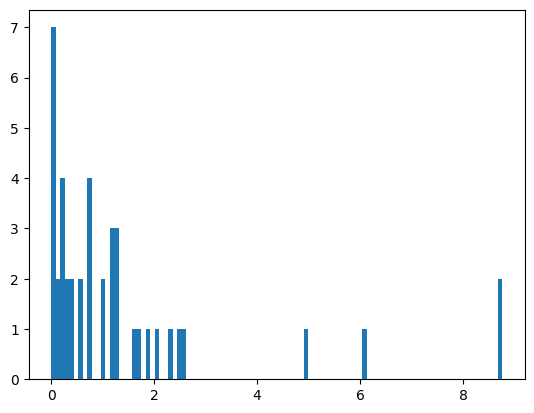

In [41]:
res_cuts = results_set100[results_set100 < 10]
plt.hist(res_cuts, bins=100, );

In [42]:
results_set100 = analysis.integrate_set_s2(run8.sets[0], t_window = (11.17, 16.17), threshold=0.8, dt = 2e-4)

In [48]:
results_set100 = replace(results_set100, areas=results_set100.areas.flatten())

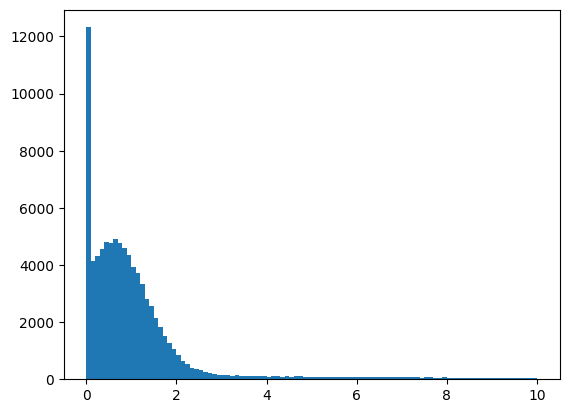

In [49]:

res_cuts = results_set100.areas[results_set100.areas < 10]
plt.hist(res_cuts, bins=100, );

S2Areas(source_dir=FieldScan_Gate100_Anode2000, n_areas=96720, method=s2_area_pipeline)

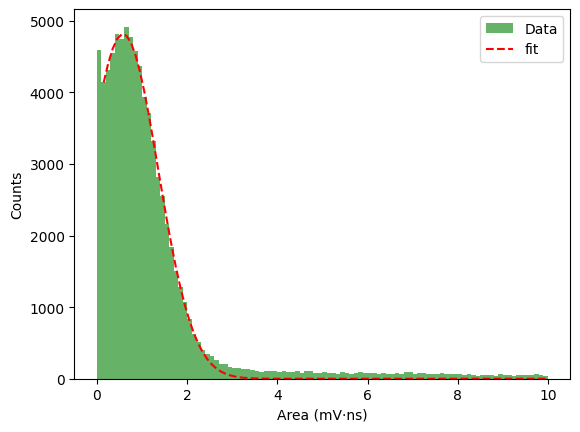

In [53]:
analysis.fit_set_s2(results_set100, bin_cuts=(0, 10), flag_plot=True)

In [54]:
dataIO.store_s2area(results_set100)

In [65]:
run8.sets[0].time_drift

np.float64(15.137548167034852)

In [61]:
dataIO.load_s2area(run8.sets[0])

S2Areas(source_dir=FieldScan_Gate100_Anode2000, n_areas=96720, method=loaded_from_npy)

In [68]:
transf.average_waveform([wfm_paths[0]])

(array([-1.50000e-05, -1.49998e-05, -1.49996e-05, ...,  3.49994e-05,
         3.49996e-05,  3.49998e-05]),
 array([-0.00043333, -0.00043333, -0.00048333, ..., -0.00045833,
        -0.00045   , -0.00043333]))

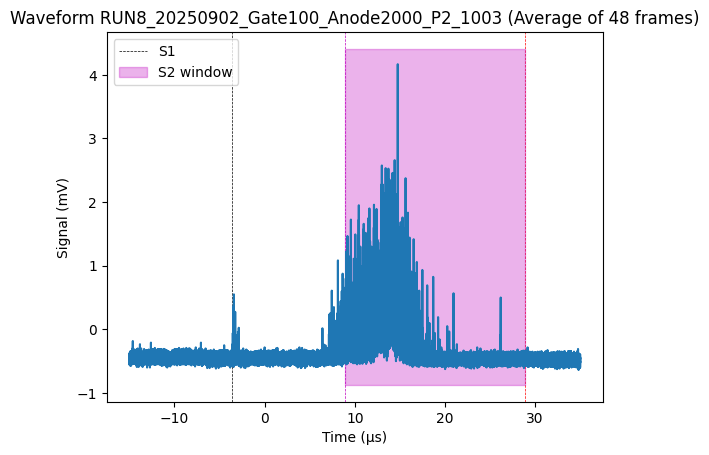

In [74]:
plotting.plot_winS2_wf(wf, t_s1=run8.sets[0].metadata['t_s1'], 
                       time_drift=run8.sets[0].time_drift, width_s2=run8.width_s2,
                       ts2_tol=-2.7)

# Test FF at run level

(<Figure size 1000x2800 with 7 Axes>,
 array([<Axes: title={'center': 'Set FieldScan_Gate100_Anode2000'}, xlabel='Time (µs)', ylabel='Signal (mV)'>,
        <Axes: title={'center': 'Set FieldScan_Gate200_Anode2100'}, xlabel='Time (µs)', ylabel='Signal (mV)'>,
        <Axes: title={'center': 'Set FieldScan_Gate300_Anode2200'}, xlabel='Time (µs)', ylabel='Signal (mV)'>,
        <Axes: title={'center': 'Set FieldScan_Gate400_Anode2300'}, xlabel='Time (µs)', ylabel='Signal (mV)'>,
        <Axes: title={'center': 'Set FieldScan_Gate500_Anode2400'}, xlabel='Time (µs)', ylabel='Signal (mV)'>,
        <Axes: title={'center': 'Set FieldScan_Gate50_Anode1950'}, xlabel='Time (µs)', ylabel='Signal (mV)'>,
        <Axes: title={'center': 'Set FieldScan_Gate600_Anode2500'}, xlabel='Time (µs)', ylabel='Signal (mV)'>],
       dtype=object))

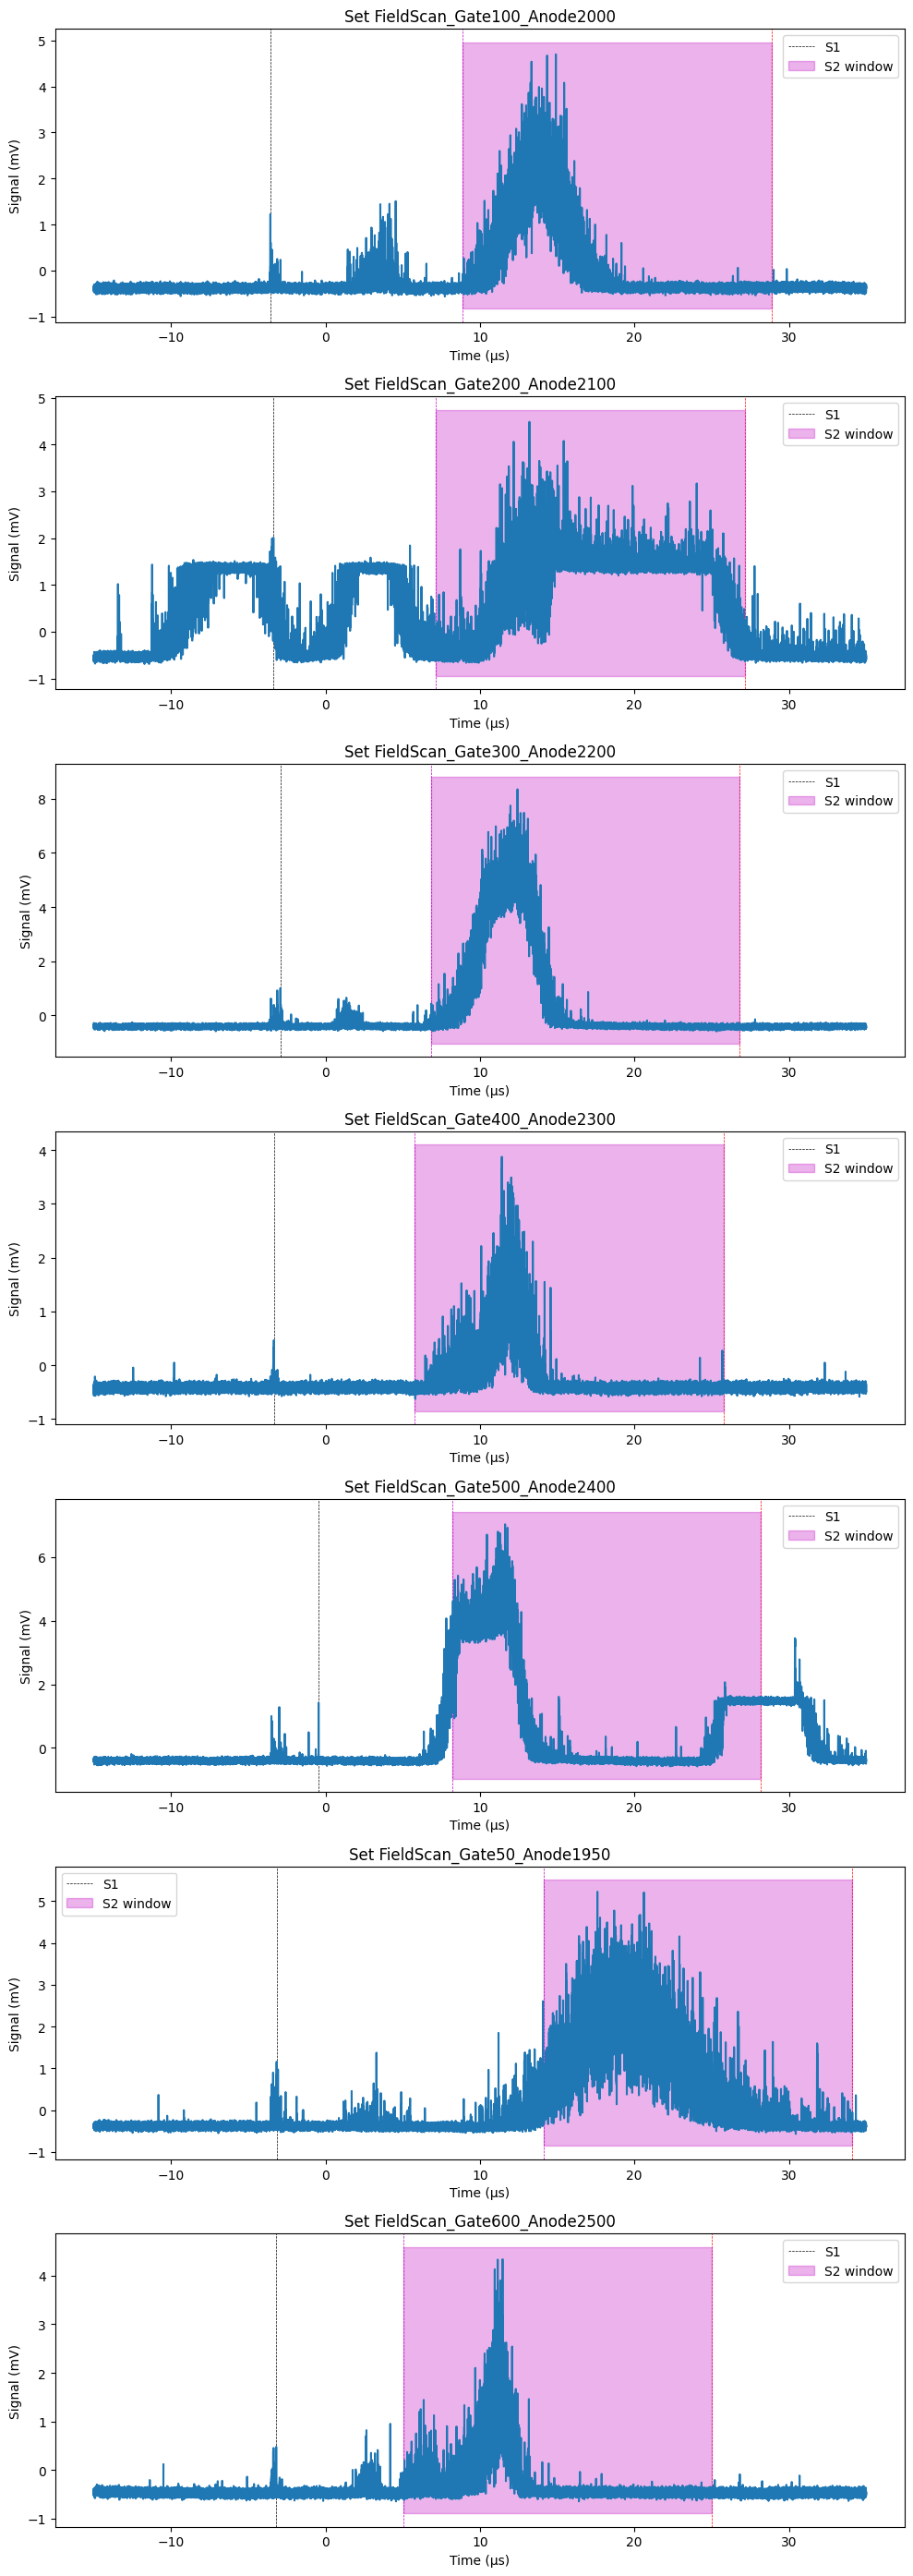

In [75]:
plotting.plot_run_winS2(run8, ts2_tol=-2.7)

In [72]:
run8.width_s2

20

In [81]:
run8.sets[2].metadata['t_s1'] = -3.32
run8.sets[4].metadata['t_s1'] = -3.32

In [ ]:
range_sets = slice(4, 7)
sets_to_process = run8.sets[range_sets] if range_sets is not None else run8.sets
for set_pmt in sets_to_process:
    print(set_pmt.source_dir, set_pmt.metadata['t_s1'], set_pmt.time_drift)

/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate500_Anode2400 -3.32 11.333863327602604
/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate50_Anode1950 -3.165 19.975595667979597


In [85]:
results_run8 = analysis.integrate_run_s2(run8, ts2_tol = -2.7, 
                                         range_sets = slice(0, 2),
                                          config=IntConfig)

Processing set /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate100_Anode2000 with t_window: (np.float64(8.871548167034852), np.float64(28.871548167034852))
Processing set /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate200_Anode2100 with t_window: (np.float64(7.140800817948338), np.float64(27.14080081794834))


In [98]:
results_run82 = analysis.integrate_run_s2(run8, ts2_tol = -2.7, 
                                         range_sets = slice(2, 4),
                                          config=IntConfig)

Processing set /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate300_Anode2200 with t_window: (np.float64(6.410697144677038), np.float64(26.410697144677037))
Processing set /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate400_Anode2300 with t_window: (np.float64(5.791509826932995), np.float64(25.791509826932995))


In [103]:
results_run84 = analysis.integrate_run_s2(run8, ts2_tol = -2.7, 
                                         range_sets = slice(4, 7),
                                          config=IntConfig)

Processing set /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate500_Anode2400 with t_window: (np.float64(5.313863327602603), np.float64(25.313863327602604))
Processing set /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate50_Anode1950 with t_window: (np.float64(14.110595667979599), np.float64(34.110595667979595))
Processing set /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate600_Anode2500 with t_window: (np.float64(5.01698318913292), np.float64(25.01698318913292))


In [99]:
results_run82

{'FieldScan_Gate300_Anode2200': S2Areas(source_dir=FieldScan_Gate300_Anode2200, n_areas=96000, method=s2_area_pipeline),
 'FieldScan_Gate400_Anode2300': S2Areas(source_dir=FieldScan_Gate400_Anode2300, n_areas=96000, method=s2_area_pipeline)}

In [ ]:
results8 = {**results_run8, **results_run82, **results_run84}

In [107]:
fitted = analysis.fit_run_s2(results8, config = config.FitConfig(bin_cuts=(0, 10)) )

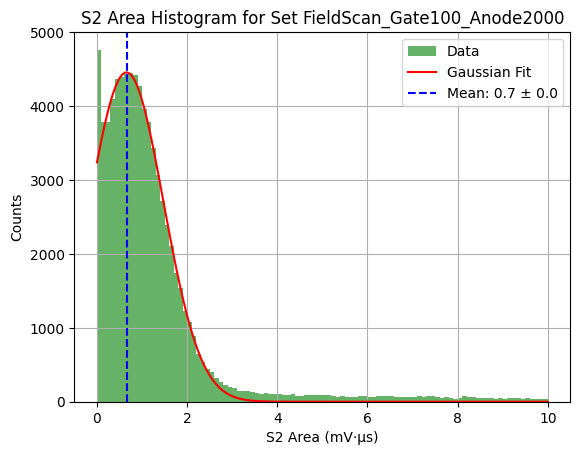

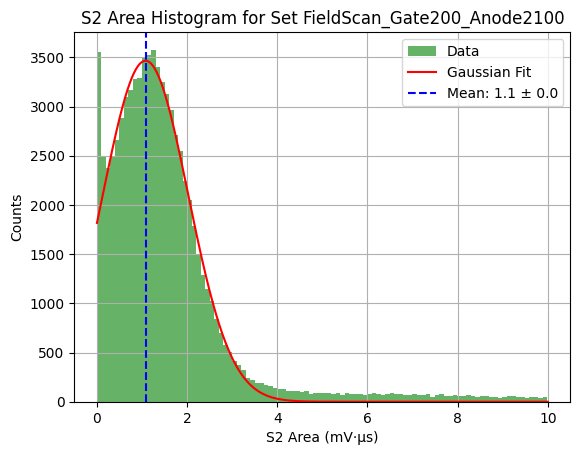

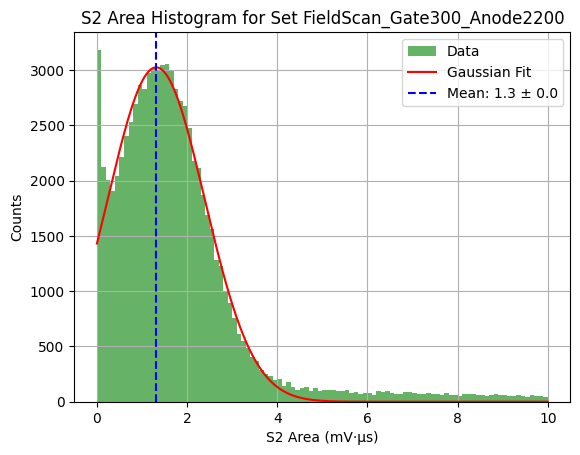

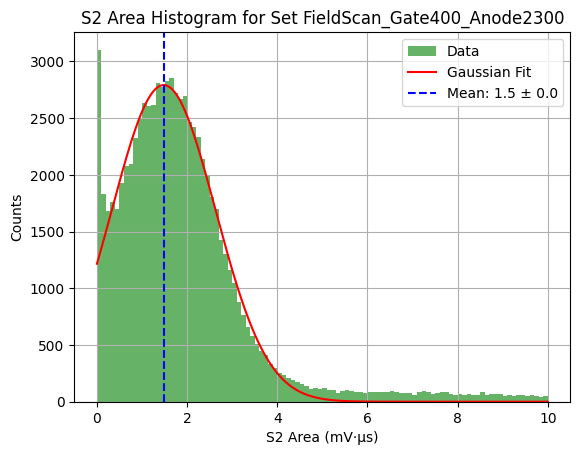

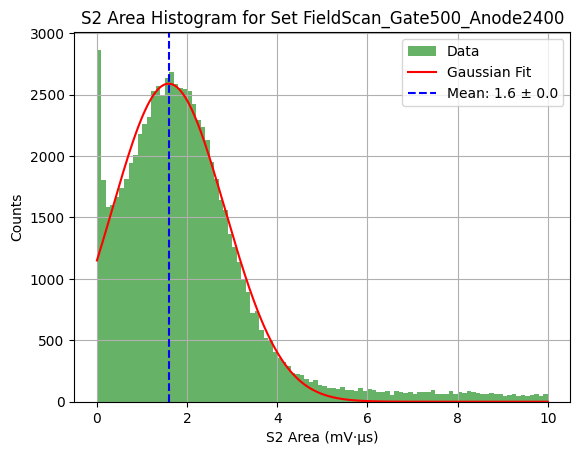

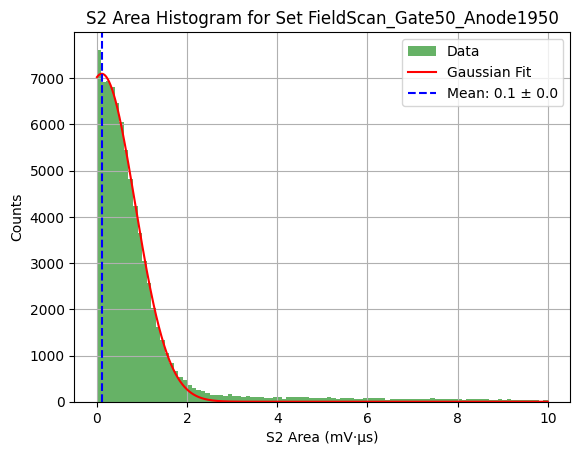

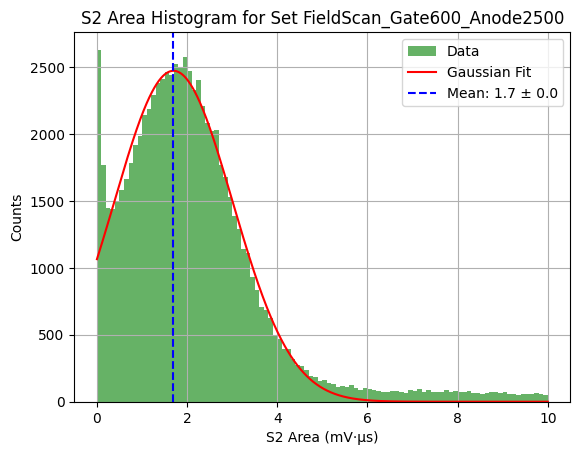

In [108]:
for set_id, fit in fitted.items():
    plotting.plot_hist_fit(fit, bin_cuts=(0, 10))

In [111]:
run8 = replace(run8, run_id = 'RUN8')

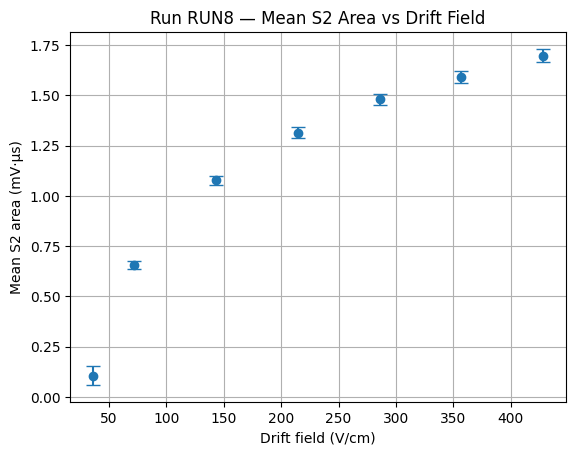

In [112]:
plotting.plot_s2_vs_drift(fitted=fitted, run=run8)